## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [162]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from plotnine import ggplot, aes, geom_point, geom_line, labs, theme_minimal

In [163]:
# Import data set
df = pd.read_csv('ha_1.csv')
df = df.dropna()
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [164]:
#Fit a Logistic Regression using only age and chol (cholesterol) as predictors.
# create a pipelin e
X = df[['age', 'chol']]
y = df['diagnosis']

ct = ColumnTransformer(
    [
    ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ], remainder='passthrough'
)
pipeline_1 = Pipeline([

    ('logistic_regrssion', LogisticRegression())])

#How high for the doctors to estimate a 90% chance that heart disease is present?
pipeline_1.fit(X, y)
model = pipeline_1.named_steps['logistic_regrssion']
# find the coefficients
coef = model.coef_
# find the intercept
intercept = model.intercept_
c_score = cross_val_score(pipeline_1, X, y, scoring = "roc_auc", cv=5).mean()
print("Intercept:", intercept)
print("Coefficients:", coef)
print("Cross Validation Score:", c_score)

Intercept: [-3.24011226]
Coefficients: [[0.04686331 0.00180124]]
Cross Validation Score: 0.6349815288434215


In [165]:
# This is the log-odds equation
logodds = np.log(.9 / (1 - .9))
logodds

2.1972245773362196

In [166]:
# This is the Logistic Regression Equation logodds=Beta0 +Beta1x1 +...Beta(k)x(k) but rearranged to solve for x2
(logodds - intercept - (.04686331 * 55)) / .00180124

array([1587.71445571])


For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [185]:
# In general we use .5 if not given a value (in Chpt 18 notes)
logodds = np.log(.5 / (1 - .5))
log_age55 = (3.24011226 - (.04686331 * 55)) / .00180124
log_age55

367.87446980968673

In [186]:
# TEsting different ages
log_age30 = (3.24011226  - (.04686331 * 30)) / .00180124
log_age80 = (3.24011226  - (.04686331 * 80)) / .00180124
print(log_age30, log_age80)

1018.3057005174214 -282.55676089804786


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [183]:
pipeline_2 = Pipeline(
  [
  ("linear_disc", LinearDiscriminantAnalysis())]
)

c_score = cross_val_score(pipeline_2, X, y, scoring = "roc_auc", cv=5).mean()
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
lda_model = pipeline_2.named_steps['linear_disc']
coef = lda.coef_[0]
intercept = lda.intercept_[0]

print("Coefficients:", coef)
print("Intercept:", intercept)
print("Cross Validation Score:", c_score)

Coefficients: [0.04655744 0.00178967]
Intercept: -3.2196776604068784
Cross Validation Score: 0.6349815288434215


In [184]:
lda_age55 = (3.2196776604068784 - (0.04655744 * 55))/0.00178967
lda_age30 =  (3.2196776604068784 - (0.04655744 * 30))/0.00178967
lda_age80 =  (3.2196776604068784 - (0.04655744 * 80))/0.00178967
print(lda_age30, lda_age55, lda_age80)

1018.5980993182421 368.23462448768686 -282.1288503428686


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [172]:
pipeline_3 = Pipeline([
    ("svc", SVC(kernel='linear'))
])

pipeline_3.fit(X, y)

Pipeline(steps=[('svc', SVC(kernel='linear'))])

In [173]:
# USed Chatgpt to reference this code
# Define the parameters of the grid
param_grid = {'svc__C': [0.1, 1, 10, 100]}

# Perform grid search
grid_search = GridSearchCV(pipeline_3, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X, y)

# This code helps us find the best model
best_params = grid_search.best_params_

print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

Best Parameters: {'svc__C': 1}
Best AUC Score: 0.6413469735720374


In [174]:
coef = pipeline_3.named_steps["svc"].coef_[0]
intercept = pipeline_3.named_steps["svc"].intercept_[0]

print("Coefficients:", coef)
print("Intercept:", intercept)

Coefficients: [0.06439772 0.00365896]
Intercept: -4.686034055211244


In [175]:
svc_age55 = (4.686034055211244 - (0.06439772 * 55))/0.00365896
svc_age30 = (4.686034055211244 - (0.06439772 * 30))/0.00365896
svc_age80 = (4.686034055211244 - (0.06439772 * 80))/0.00365896
print(svc_age30, svc_age55, svc_age80)

752.7008918411907 312.70072786016885 -127.29943612085302


## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [176]:
log_df = []
log_df.append({"Age": 30, "Chol": log_age30})
log_df.append({"Age": 55, "Chol": log_age55})
log_df.append({"Age": 80, "Chol": log_age80})

log_df = pd.DataFrame(log_df)

lda_df = []
lda_df.append({"Age": 30, "Chol": lda_age30})
lda_df.append({"Age": 55, "Chol": lda_age55})
lda_df.append({"Age": 80, "Chol": lda_age80})

lda_df = pd.DataFrame(lda_df)

svc_df = []
svc_df.append({"Age": 30, "Chol": svc_age30})
svc_df.append({"Age": 55, "Chol": svc_age55})
svc_df.append({"Age": 80, "Chol": svc_age80})

svc_df = pd.DataFrame(svc_df)


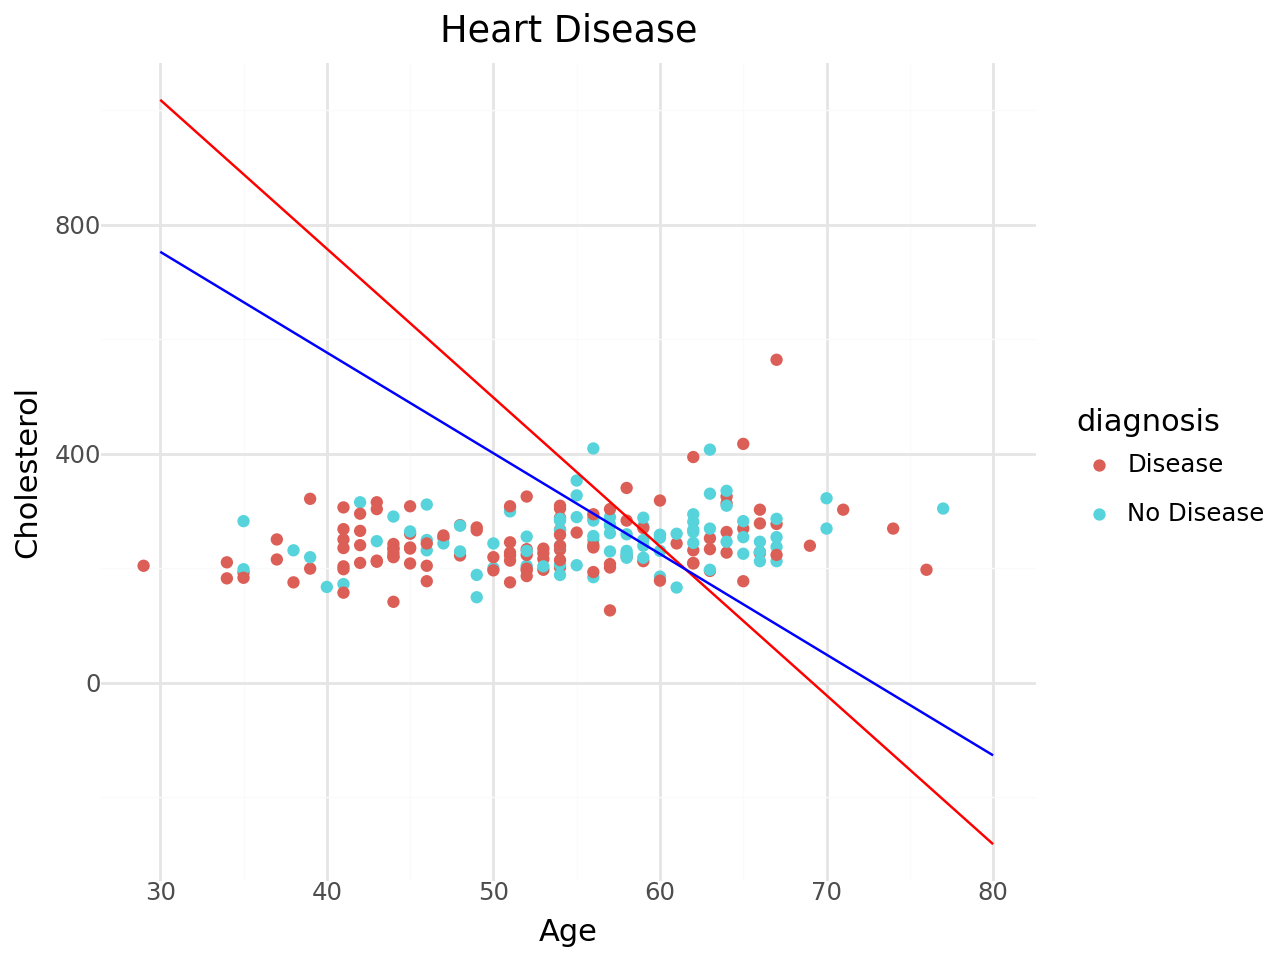

In [181]:
(ggplot(df, aes(x="age", y="chol", color="diagnosis"))
    + geom_point()
    + geom_line(aes(x="Age", y="Chol"), data=log_df, color="red")
    + geom_line(aes(x="Age", y="Chol"), data=lda_df, color="green")
    + geom_line(aes(x="Age", y="Chol"), data=svc_df, color="blue")
    #add theme
    + labs(x="Age", y="Cholesterol", title="Heart Disease")
    + theme_minimal()
)

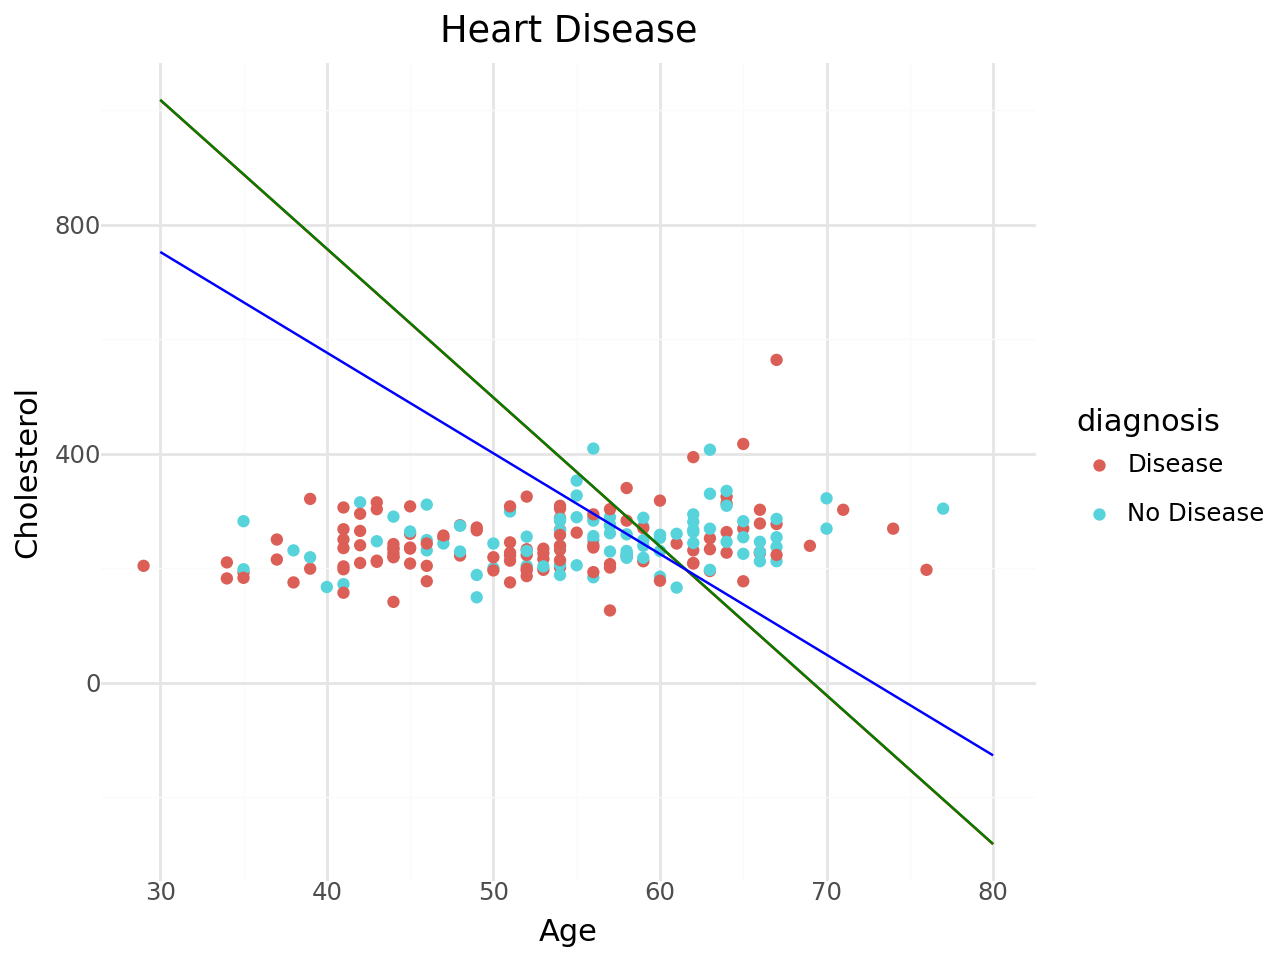

In [178]:
(ggplot(df, aes(x="age", y="chol", color="diagnosis"))
    + geom_point()
    + geom_line(aes(x="Age", y="Chol"), data=log_df, color="red")
    #+ geom_line(aes(x="Age", y="Chol"), data=lda_df, color="green")
    + geom_line(aes(x="Age", y="Chol"), data=svc_df, color="blue")
    #add theme
    + labs(x="Age", y="Cholesterol", title="Heart Disease")
    + theme_minimal())

My line for my lda and log were practically identical I am unsure what I was doing wrong in my log model I changed it a few times and I was getting frustrated after constantly messing with it. I kept getting into more issue so I left what last worked.